In [1]:
import jax.numpy as jnp
import pyccl as ccl
import pyccl.halos as halos
import matplotlib.pylab as plt

from jax_cosmo.core import Cosmology
import jax_cosmo.power as jcp
from jax_cosmo.halos.hmbase import compute_sigma, calculate_mass_function
from jax_cosmo.halos.hmfunc import JAXMassFuncBocquet16

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 12

jcp.USE_EMU = True

In [2]:
cosmo_jax = Cosmology(Omega_c=0.2650,
                      Omega_b=0.0492,
                      h=0.6724,
                      sigma8 = 0.811,
                      n_s=0.9645,
                      Omega_k=0.,
                      w0=-1.,
                      wa=0.,
                     Neff = 3.044)

cosmo_ccl = ccl.Cosmology(Omega_c=0.2650,
                          Omega_b=0.0492,
                          h=0.6724,
                          sigma8 = 0.811,
                          n_s=0.9645,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu',
                          matter_power_spectrum='halofit')

## Halo Mass Function

In [3]:
interpolator = compute_sigma(cosmo_jax)

In [4]:
m_arr = jnp.geomspace(1.01E12,1E15,128) / cosmo_ccl['h']
z_grid = jnp.linspace(0, 1, 10)

In [5]:
# JAXMassFuncAngulo12()
# JAXMassFuncBocquet16()
# JAXMassFuncDespali16()
# JAXMassFuncTinker08()
# JAXMassFuncTinker10()
# JAXMassFuncWatson13() -> In CCL: halos.MassFuncWatson13(mass_def=ccl.halos.MassDefFof)
# JAXMassFuncSheth99()
# JAXMassFuncPress74()
# JAXMassFuncJenkins01()

jax_hm_func = JAXMassFuncBocquet16()
ccl_hm_func = halos.MassFuncBocquet16()

record_mf_ccl = []
record_mf_jax = []

for z in z_grid:
    a = 1.0 / (1.0 + z)
    mf_ccl = ccl_hm_func(cosmo_ccl, m_arr, a.item())
    mf_jax, _ = calculate_mass_function(cosmo_jax, m_arr, a, jax_hm_func, interpolator)
    record_mf_ccl.append(mf_ccl)
    record_mf_jax.append(mf_jax)

record_mf_ccl = jnp.asarray(record_mf_ccl).T
record_mf_jax = jnp.asarray(record_mf_jax).T

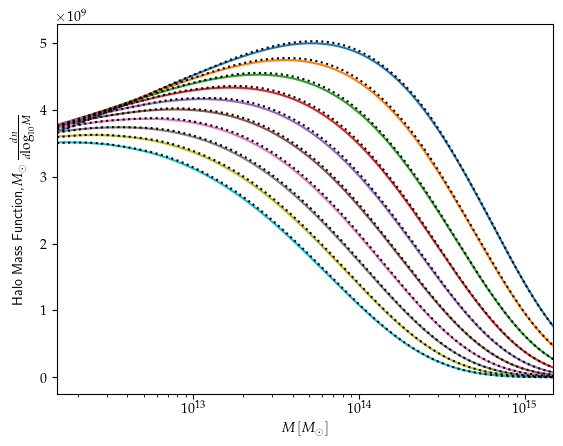

In [6]:
plt.plot(m_arr, m_arr.reshape(-1,1) * record_mf_ccl)
plt.plot(m_arr, m_arr.reshape(-1,1) * record_mf_jax, linestyle = ':', color = 'k')
plt.ylabel(r'Halo Mass Function,' + r'$M_{\odot}\,\frac{dn}{d\textrm{log}_{10}M}$')
plt.xlabel(r'$M\,[M_{\odot}]$')
plt.xlim(min(m_arr), max(m_arr))
plt.xscale('log')
plt.show()

## Halo Bias

In [7]:
from jax_cosmo.halos.hmbase import get_logM_sigM
from jax_cosmo.halos.hmbias import HaloBiasBhattacharya11

In [8]:
ccl_halo_bias = halos.HaloBiasBhattacharya11()
jax_halo_bias = HaloBiasBhattacharya11()

record_bias_ccl = []
record_bias_jax = []

for z in z_grid:
    a = 1.0 / (1.0 + z)
    bias_ccl = ccl_halo_bias(cosmo_ccl, m_arr, a.item())

    # we need to compute \sigma_M for a given mass
    log_mass, sigma_mass, dlns_dlogM = get_logM_sigM(cosmo_jax, m_arr, a.item(), interpolator)
    bias_jax = jax_halo_bias.compute_bias(cosmo_jax, sigma_mass, a.item())

    record_bias_ccl.append(bias_ccl)
    record_bias_jax.append(bias_jax)

In [9]:
record_bias_ccl = jnp.asarray(record_bias_ccl)
record_bias_jax = jnp.asarray(record_bias_jax)

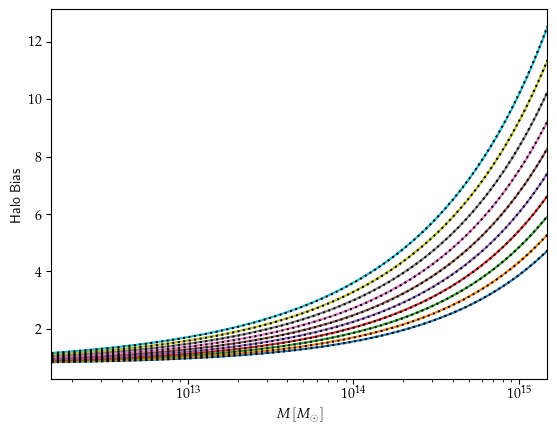

In [10]:
plt.plot(m_arr, record_bias_ccl.T)
plt.plot(m_arr, record_bias_jax.T, c = 'k', linestyle = ':')
plt.ylabel(r'Halo Bias')
plt.xlabel(r'$M\,[M_{\odot}]$')
plt.xlim(min(m_arr), max(m_arr))
plt.xscale('log')
plt.show()

## Concentration

In [11]:
from pyccl.halos.concentration import ConcentrationIshiyama21
from jax_cosmo.halos.concentration import JAXConIshiyama21

In [12]:
record_conc_ccl = []
record_conc_jax = []

conc_ccl = ConcentrationIshiyama21()
conc_jax = JAXConIshiyama21()

for z in z_grid:
    a = 1.0 / (1.0 + z)
    concenctration_ccl = conc_ccl(cosmo_ccl, m_arr, a.item())
    concenctration_jax = conc_jax.compute_concentration(cosmo_jax, m_arr, a.item(), interpolator)

    record_conc_ccl.append(concenctration_ccl)
    record_conc_jax.append(concenctration_jax)

In [13]:
record_conc_ccl = jnp.asarray(record_conc_ccl)
record_conc_jax = jnp.asarray(record_conc_jax)

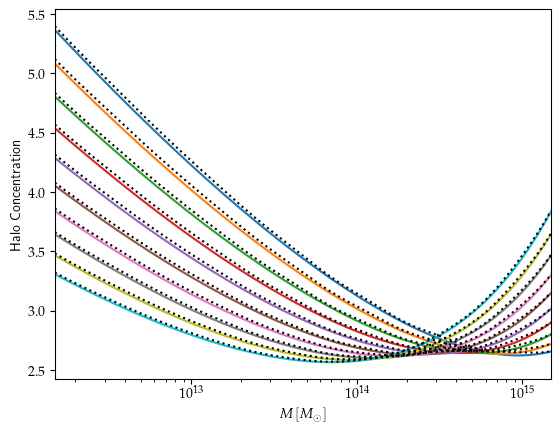

In [14]:
plt.figure()
plt.plot(m_arr, record_conc_ccl.T)
plt.plot(m_arr, record_conc_jax.T, c = 'k', linestyle = ':')
plt.ylabel(r'Halo Concentration')
plt.xlabel(r'$M\,[M_{\odot}]$')
plt.xlim(min(m_arr), max(m_arr))
plt.xscale('log')
plt.show()

## Halo Profile